# **Quantitative assessment of clearing protocols**
### Written by Deniz Bekat (*deniz.bekat@crick.ac.uk*)


### This programme is a semi-automated, easy-to-use workflow designed to assess multi-dimensional fluorescence images and produce quantitative parameters so **you** can make a decision on which clearing protocol is best for you!

In [1]:
# importing required libraries

#image and metadata import
from bioio import BioImage
import bioio_bioformats
import bioio_ome_tiff

# data processing and computation
import numpy as np
import pandas as pd
from scipy.ndimage import binary_fill_holes, distance_transform_edt
from skimage import io, morphology, measure, filters, restoration
from cellpose import models
from scipy.signal import find_peaks
from stardist.models import StarDist2D
from csbdeep.utils import normalize
from stitching import stitch_2d_to_3d_fast

# data visualisation and saving
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tf

#file handling
import glob
import os

2026-01-27 14:12:31.991396: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Importing your image and its metadata**

#### Here, we are going to import your image into the Python script using the `bioio` library: this uses a function called `BioImage` to import your image and all the relevant metadata for analysis

In [2]:
im_read = BioImage(
    './test_inputs/test.ome.tif')  # this will read your image file based on the relative path and your image file name

In [3]:
# producing the metadata of your image

print(im_read.dims)

x_res = im_read.physical_pixel_sizes.X
y_res = im_read.physical_pixel_sizes.Y
z_res = im_read.physical_pixel_sizes.Z

ani = round(z_res / x_res, 2)

print(f"Resolution of X (µm): {im_read.physical_pixel_sizes.X}")
print(f"Resolution of Y (µm): {im_read.physical_pixel_sizes.Y}")
print(f"Resolution of Z (µm): {im_read.physical_pixel_sizes.Z}")

<Dimensions [T: 1, C: 1, Z: 15, Y: 512, X: 512]>
Resolution of X (µm): 0.1180000037760001
Resolution of Y (µm): 0.1180000037760001
Resolution of Z (µm): 0.1180000037760001


In [4]:
im_read.standard_metadata  # some extra information on the metadata of the image

StandardMetadata(binning=None, column=None, dimensions_present='TCZYX', image_size_c=1, image_size_t=1, image_size_x=512, image_size_y=512, image_size_z=15, imaged_by=None, imaging_datetime=None, objective=None, pixel_size_x=0.1180000037760001, pixel_size_y=0.1180000037760001, pixel_size_z=0.1180000037760001, position_index=None, row=None, timelapse=True, timelapse_interval=None, total_time_duration=None)

#### For most of this analysis, we want to mainly use the **nuclear channel** - we can introduce another variable here called `im_nuclear` that holds only the nuclear channel.

#### NOTE: only do this if your sample has multiple channels!

In [5]:
nuclear_channel_no = 3  # enter the channel number of your nuclear marker here - don't forget that Python starts counting at 0!

if im_read.standard_metadata.image_size_c > 1:
    im_nuclear = im_read.data[0][nuclear_channel_no]
else:
    im_nuclear = im_read.data[0][
        0]  #im_nuclear becomes a numpy array, removing the time and channel dimensions since they are unused


## **Visualising your image**

#### *Looking* at your data is a crucial step, to check everything is working, and that you're seeing what you expect. Here's a quick visualisation of your image:

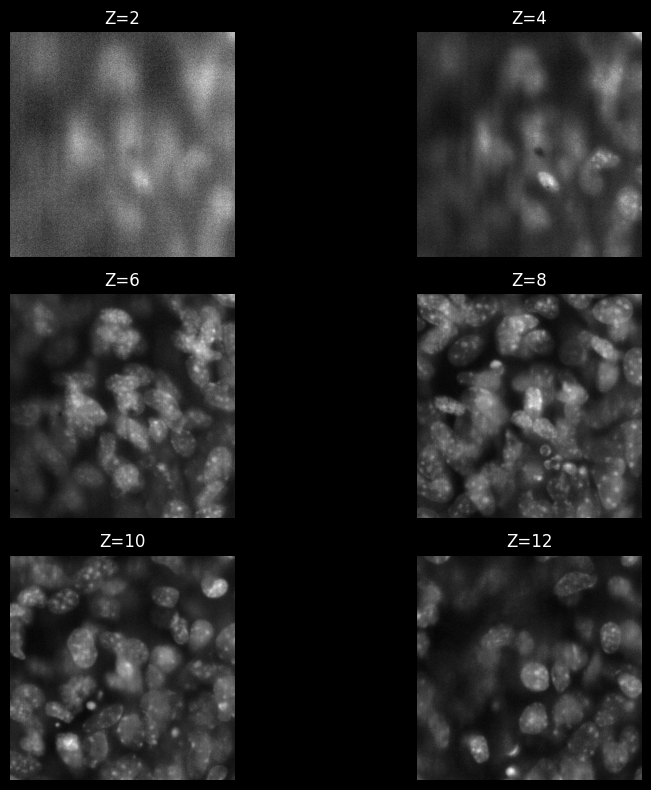

In [6]:
# display some z slices to display the data throughout

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

axs[0, 0].imshow(im_nuclear[int(im_nuclear.shape[0] / 7),], cmap='gray')
axs[0, 0].set_title(f'Z={int(im_nuclear.shape[0] / 7)}')
axs[0, 0].axis('off')

axs[0, 1].imshow(im_nuclear[int(2 * im_nuclear.shape[0] / 7),], cmap='gray')
axs[0, 1].set_title(f'Z={int(2 * im_nuclear.shape[0] / 7)}')
axs[0, 1].axis('off')

axs[1, 0].imshow(im_nuclear[int(3 * im_nuclear.shape[0] / 7),], cmap='gray')
axs[1, 0].set_title(f'Z={int(3 * im_nuclear.shape[0] / 7)}')
axs[1, 0].axis('off')

axs[1, 1].imshow(im_nuclear[int(4 * im_nuclear.shape[0] / 7),], cmap='gray')
axs[1, 1].set_title(f'Z={int(4 * im_nuclear.shape[0] / 7)}')
axs[1, 1].axis('off')

axs[2, 0].imshow(im_nuclear[int(5 * im_nuclear.shape[0] / 7),], cmap='gray')
axs[2, 0].set_title(f'Z={int(5 * im_nuclear.shape[0] / 7)}')
axs[2, 0].axis('off')

axs[2, 1].imshow(im_nuclear[int(6 * im_nuclear.shape[0] / 7),], cmap='gray')
axs[2, 1].set_title(f'Z={int(6 * im_nuclear.shape[0] / 7)}')
axs[2, 1].axis('off')

plt.tight_layout()

## **Measuring statistical parameters**

#### Uncleared samples, due to light scattering, can degrade in intensity and in the contrast of the image. To measure this, we measure the mean and standard deviation per unit depth using `numpy`.

#### To do this, we analyse each 2D slice of the image, where we:
- ##### Identify the areas of the image where the sample is present, using thresholding algorithms `skimage.filters` - this lets us create a **binary mask**.
- ##### Measure the mean and standard deviation using `np.mean()` and `np.std()` for parts of the image identified as sample
- ##### Save those values, along with the relevant dimension in Z, to track **how these values change with depth**

#### We can then compare the results from different samples to compare their properties!

In [7]:
# measuring properties per image slice; plot across z to see how properties change with image thickness
mean = []
standard_dev = []

for z in range(0, len(im_nuclear)):  #checks through every slice

    slice = im_nuclear[z]

    slice_thresh = filters.threshold_li(slice)
    slice_bin = slice >= slice_thresh

    mean_val = np.mean(slice[slice_bin > 0])
    std_val = np.std(slice[slice_bin > 0])

    mean.append(mean_val)
    standard_dev.append(std_val)

step_size_Z = im_read.physical_pixel_sizes.Z  #change depending on the step size of the acquired image

df = pd.DataFrame({
    "Slice": np.arange(len(mean)) + 1,
    "Mean Intensity": mean,
    "Std Dev": standard_dev
})

df['Imaging depth'] = df['Slice'] * step_size_Z
df['Clearing'] = "ECi"  # this is the KEY PART! change this to whichever clearing protocol you're using!

df.head()

,Slice,Mean Intensity,Std Dev,Imaging depth,Clearing
0,1,3131.789474,470.198550,0.118,ECi
1,2,3687.892143,572.343601,0.236,ECi
2,3,4356.224240,717.171489,0.354,ECi
3,4,5451.319350,1062.609946,0.472,ECi
4,5,7573.389454,1868.016978,0.590,ECi


## **Normalising results**

#### Since the raw pixel intensity values can differ between samples, microscope system, or stain, we must *normalise* the data to be able to compare different images together.
#### Here we introduce some functions that will normalise the mean and standard deviation:

In [8]:
# normalisation

def normalise_mean(df):  # mean intensity normalisation

    dmin = np.min(df['Mean Intensity'])
    dmax = np.max(df['Mean Intensity'])

    df['Normalised Mean'] = 100 * (df['Mean Intensity'] - dmin) / (dmax - dmin)

    return df


def normalise_std(df):  # standard deviation normalisation

    dmin = np.min(df['Std Dev'])
    dmax = np.max(df['Std Dev'])

    df['Normalised Std Dev'] = 100 * (df['Std Dev'] - dmin) / (dmax - dmin)

    return df




#### We must also find a way to remove some 'junk' data - for example, this could include the pixel value measurements from any z-slices of the image where the sample isn't there!

In [9]:
"""
The plots of intensity and standard deviation peak at the very beginning - comparing the relevant z-slice on your image, you can see this is where your sample comes into focus!
So, anything from before that point is measuring noise - we can simply ignore it
"""


def find_first_peak(df):
    y = df["Mean Intensity"].values  # takes all the values of y

    dy = np.diff(y)  # differential of y
    peak_positions = np.where((dy[:-1] > 0) & (dy[1:] < 0))[0] + 1  # measures the first peak (where dy/dx = 0)

    return df.index[peak_positions[0]]


def normalise_start(df):
    peak_idx = find_first_peak(df)  #finds the first peak index in the data

    peak_depth = df.loc[
        peak_idx, "Slice"]  # uses the first peak index to find the Z slice where the sample first comes into focus

    df["Peak Depth"] = peak_depth
    df["Aligned Depth"] = step_size_Z * (df[
                                             "Slice"] - peak_depth)  # removes data before the point of the sample, so the first instance of seeing your sample is Z=0

    return df

In [10]:
# applying functions to your data
normalise_mean(df)
normalise_std(df)
normalise_start(df)

# removing 'junk data' before the peak
clean_data = df[df['Aligned Depth'] > 0]
clean_data.tail()


,Slice,Mean Intensity,Std Dev,Imaging depth,Clearing,Normalised Mean,Normalised Std Dev,Peak Depth,Aligned Depth
10,11,15276.965779,3814.800709,1.298,ECi,97.917956,95.531494,9,0.236
11,12,15121.045229,3756.912381,1.416,ECi,96.660879,93.878036,9,0.354
12,13,14626.281213,3597.435241,1.534,ECi,92.671947,89.322908,9,0.472
13,14,14214.410484,3971.245199,1.652,ECi,89.351325,100.000000,9,0.590
14,15,13713.466657,3276.397139,1.770,ECi,85.312570,80.153133,9,0.708


Text(0, 0.5, 'Normalised Mean Intensity')

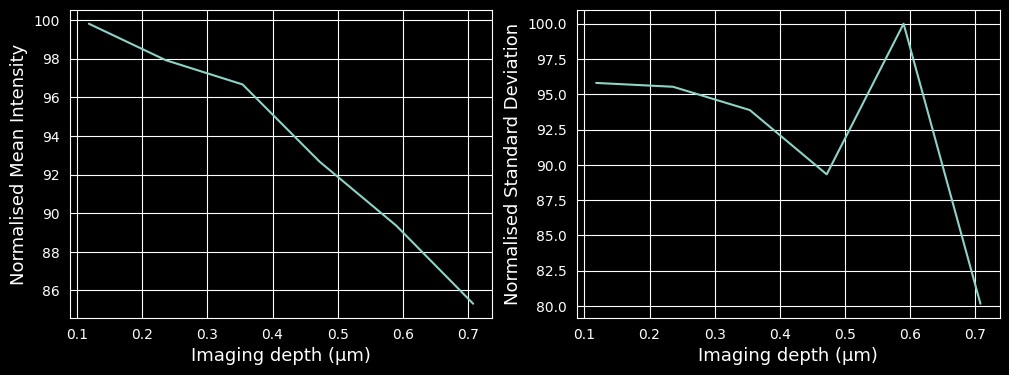

In [11]:
# visualising results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    data=clean_data,
    x='Aligned Depth',
    y='Normalised Mean',
    ax=axs[0]
)

sns.lineplot(
    data=clean_data,
    x='Aligned Depth',
    y='Normalised Std Dev',
    ax=axs[1]
)

axs[0].grid(True)
axs[1].grid(True)

axs[1].set_xlabel("Imaging depth (µm)", fontsize=13)
axs[0].set_xlabel("Imaging depth (µm)", fontsize=13)

axs[1].set_ylabel("Normalised Standard Deviation", fontsize=13)
axs[0].set_ylabel("Normalised Mean Intensity", fontsize=13)

## **Cell detection**
### While measuring pixel intensities is useful, it gives very little information on what *biological information* you can see, for example:
- #### if you can detect more cells/nuclei with a cleared sample
- #### if your sample has shrank or expanded due to a clearing protocol




### 3D nuclei detection with stardist

In [12]:
model_name = '2D_versatile_fluo'
print(f"Loading StarDist model: {model_name}")
model = StarDist2D.from_pretrained(model_name)
nuc_labels = np.empty(im_nuclear.shape)

for i in range(im_nuclear.shape[0]):
    print(f'Detecting nuclei in slice {(i + 1)} of {im_nuclear.shape[0]}')

    # Normalize image (StarDist expects normalized input)
    img_normalized = normalize(im_nuclear[i], 1, 99.8)

    # Run StarDist prediction
    nuc_labels[i], details = model.predict_instances(img_normalized)

    print(f"  -> Detected {nuc_labels[i].max()} objects")

segmentation_3d, stats = stitch_2d_to_3d_fast(nuc_labels)

Loading StarDist model: 2D_versatile_fluo
Found model '2D_versatile_fluo' for 'StarDist2D'.


I0000 00:00:1769523678.732400   64822 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79079 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
Detecting nuclei in slice 1 of 15


2026-01-27 14:21:20.677030: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f29e800a9e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-27 14:21:20.677051: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2026-01-27 14:21:20.717339: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-27 14:21:20.906639: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 90300
I0000 00:00:1769523682.258928   67353 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  -> Detected 0.0 objects
Detecting nuclei in slice 2 of 15
  -> Detected 0.0 objects
Detecting nuclei in slice 3 of 15
  -> Detected 0.0 objects
Detecting nuclei in slice 4 of 15
  -> Detected 3.0 objects
Detecting nuclei in slice 5 of 15
  -> Detected 22.0 objects
Detecting nuclei in slice 6 of 15
  -> Detected 60.0 objects
Detecting nuclei in slice 7 of 15
  -> Detected 78.0 objects
Detecting nuclei in slice 8 of 15
  -> Detected 91.0 objects
Detecting nuclei in slice 9 of 15
  -> Detected 111.0 objects
Detecting nuclei in slice 10 of 15
  -> Detected 92.0 objects
Detecting nuclei in slice 11 of 15
  -> Detected 96.0 objects
Detecting nuclei in slice 12 of 15
  -> Detected 79.0 objects
Detecting nuclei in slice 13 of 15
  -> Detected 64.0 objects
Detecting nuclei in slice 14 of 15
  -> Detected 54.0 objects
Detecting nuclei in slice 15 of 15
  -> Detected 59.0 objects

FAST 3D STITCHING (OPTIMIZED + PARALLEL)
Input shape: (15, 512, 512)
IoU threshold: 0.3
Workers: 8

Slice   10/15 |

## Visualise segmentation results

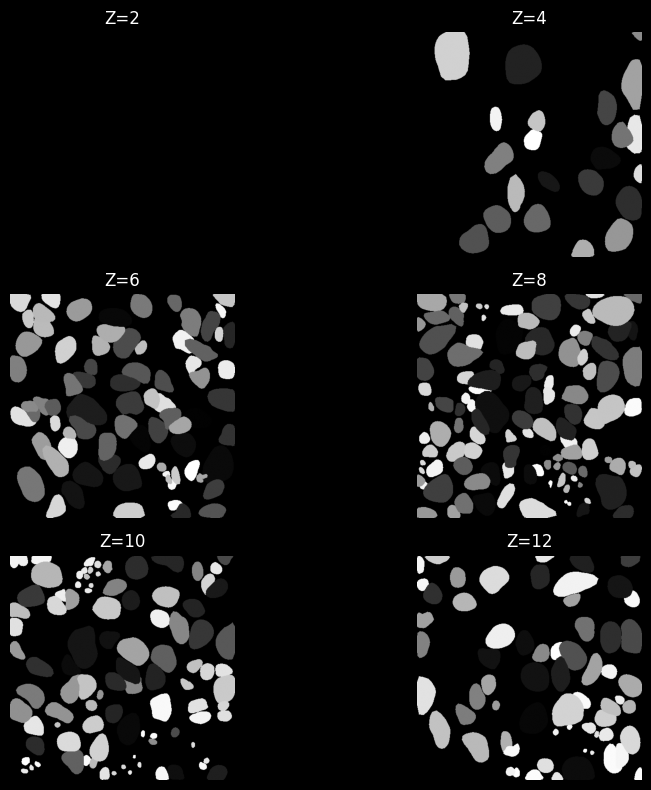

In [13]:
# display some z slices to display the data throughout

fig, axs = plt.subplots(3, 2, figsize=(10, 8))

axs[0, 0].imshow(segmentation_3d[int(segmentation_3d.shape[0] / 7),], cmap='gray')
axs[0, 0].set_title(f'Z={int(segmentation_3d.shape[0] / 7)}')
axs[0, 0].axis('off')

axs[0, 1].imshow(segmentation_3d[int(2 * segmentation_3d.shape[0] / 7),], cmap='gray')
axs[0, 1].set_title(f'Z={int(2 * segmentation_3d.shape[0] / 7)}')
axs[0, 1].axis('off')

axs[1, 0].imshow(segmentation_3d[int(3 * segmentation_3d.shape[0] / 7),], cmap='gray')
axs[1, 0].set_title(f'Z={int(3 * segmentation_3d.shape[0] / 7)}')
axs[1, 0].axis('off')

axs[1, 1].imshow(segmentation_3d[int(4 * segmentation_3d.shape[0] / 7),], cmap='gray')
axs[1, 1].set_title(f'Z={int(4 * segmentation_3d.shape[0] / 7)}')
axs[1, 1].axis('off')

axs[2, 0].imshow(segmentation_3d[int(5 * segmentation_3d.shape[0] / 7),], cmap='gray')
axs[2, 0].set_title(f'Z={int(5 * segmentation_3d.shape[0] / 7)}')
axs[2, 0].axis('off')

axs[2, 1].imshow(segmentation_3d[int(6 * segmentation_3d.shape[0] / 7),], cmap='gray')
axs[2, 1].set_title(f'Z={int(6 * segmentation_3d.shape[0] / 7)}')
axs[2, 1].axis('off')

plt.tight_layout()

### 2D nuclei detection with cellpose

In [ ]:
# initialise Cellpose model in our code
model = models.Cellpose(gpu=True)

In [ ]:
# nuclei detection - here, we use a library called Cellpose (a deep-learning algorithm for nuclei detection)

mask_slices = []
props_df = pd.DataFrame()  #empty DataFrame to add all data to

for n in range(0, len(im_nuclear)):  #loops through every z-slice in your image
    slice = im_nuclear[n]

    masks, flows, styles, diams = model.eval(slice, diameter=13, flow_threshold=2,
                                             cellprob_threshold=-1)  # cell detection using cellpose

    print(f"z={n}")
    print(f"Number of nuclei detected:{np.max(masks)}")

    nuclei_props = measure.regionprops_table(masks, slice, properties=['area', 'mean_intensity', 'eccentricity',
                                                                       'centroid'])  # uses a function to measure the properties of each nuclei detected
    nuclei_props = pd.DataFrame(nuclei_props)

    edge_distance = distance_transform_edt(mask[n])  #calculates distance map for binary mask of sample
    nuclei_distances = []

    for idx, row in nuclei_props.iterrows():  #finds x and y centroid coordinates for each nucleus detected
        cy = int(row['centroid-0'])
        cx = int(row['centroid-1'])

        dist = edge_distance[cy, cx]  # measures the distance of each nucleus centroid from the edge (added parameter)
        nuclei_distances.append(dist)

    nuclei_props['Slice'] = n
    nuclei_props['nuclei_per_slice'] = np.max(masks)
    nuclei_props['distance_from_edge'] = nuclei_distances

    props_df = pd.concat([props_df, nuclei_props], ignore_index=True)  # adds data from slice into DataFrame

    slice_binmask = masks > 0
    fig, axs = plt.subplots(1, 2,
                            figsize=(12, 8))  # plots the raw data and the detected nuclei side by side per iteration

    axs[0].imshow(slice, cmap='gray')
    axs[0].axis('off')

    axs[1].imshow(slice_binmask, cmap='gray')
    axs[1].axis('off')

    plt.show()

In [ ]:
props_df['Imaging depth'] = props_df['Slice'] * z_res
props_df['Clearing'] = 'ECi'  # this is the KEY PART! change this to whichever clearing protocol you're using!
props_df.tail()

## **Normalising Cell Data**

### Similar to the statistical measurements, we have to clean our cell detection data to make sure any significant differences are valid.
### Here, we are adjusting for differences in the start of the sample, similar to before:

In [ ]:
# create function to find the 'peak' for nuclei detections per dataset

def find_nuclei_peak(df):
    nuclei_data = df['nuclei_per_slice']
    nuclei_data = pd.unique(nuclei_data.to_numpy())  # creates a 1D array of the detected nuclei per slice

    peaks = find_peaks(nuclei_data)
    print(peaks)

    return peaks[0][0]


def normalise_cell_start(df):
    peak_idx = find_nuclei_peak(df)  #finds the first peak index in the data

    peak_depth = df.iloc[peak_idx][
        "Slice"]  # uses the first peak index to find the Z slice where the sample first comes into focus

    df["Peak Depth"] = peak_depth
    df["Aligned Depth"] = step_size_Z * (df[
                                             "Slice"] - peak_depth)  # removes data before the point of the sample, so the first instance of seeing your sample is Z=0

    return df


In [ ]:
# apply function to data
normalise_cell_start(props_df)
props_df = props_df[props_df['Aligned Depth'] > 0]

### Then, we can visualise our data to see if the results are what we expect:

In [ ]:
# visualising data and QC

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

sns.lineplot(
    data=props_df,
    x='Aligned Depth',
    y='nuclei_per_slice',
    ax=axs[0]
)

sns.lineplot(
    data=props_df,
    x='Aligned Depth',
    y='eccentricity',
    ax=axs[1]
)

sns.lineplot(
    data=props_df,
    x='Aligned Depth',
    y='area',
    ax=axs[2]
)

axs[0].grid(True)
axs[1].grid(True)
axs[2].grid(True)

axs[0].set_xlabel("Imaging depth (µm)", fontsize=13)
axs[1].set_xlabel("Imaging depth (µm)", fontsize=13)
axs[2].set_xlabel("Imaging depth (µm)", fontsize=13)

axs[0].set_ylabel("Nuclei detections", fontsize=13)
axs[1].set_ylabel("Nuclear eccentricity", fontsize=13)
axs[2].set_ylabel("Nuclear area (px)", fontsize=13)


## **Measuring morphology change**

### Clearing protocols often shrink or expand the sample: this can be measured by comparing the are of the MIP of the sample in different conditions.
### Luckily, we already measured this earlier! So we can just add it to our pandas DataFrame(s) to save it.

In [ ]:
# producing MIP from nuclear channel

mip = np.max(im_nuclear,
             axis=0)  # MIP is made by finding the max intensity at any pixel in the (X,Y) plane through Z; think of it as 'squishing' a 3D image down so only the brightest spots per pixel is left!

plt.imshow(mip, cmap='gray')  # visualise the MIP - this should be a single 2D image!
plt.axis('off')
plt.show()

In [ ]:
# finding the midpoint of the MIP

mip_thresh = filters.threshold_li(mip)  #using segmentation to identify the MIP from the background
binary_mip = mip >= mip_thresh

clean_labels = (binary_mip > 0).astype(np.uint8)
mip_props = measure.regionprops_table(clean_labels, mip, properties=[
    'area'])  #measures the centroid for all objects detected within the binary mask - in this case, this is just the MIP!

area = round((int(mip_props['area']) * (x_res * x_res)), 2)  # calculates area in square µm

clean_data['mip_area'] = area  # saves MIP area data into dataframe
clean_data.tail()  # view the first 5 rows of data as a check

## **Saving your data**

### Since the data we've collected so far is stored in a pandas DataFrame, which is very similar to a .csv, we can convert it so all your data is stored in a `.csv` file!
### This way, you can have a `.csv` file for each sample you image, and use tgem compare the clearing protocols using the parameters measured.

In [ ]:
# saving data into .csv files

clean_data.to_csv("cal127-2B2_ECi_stats-data.csv")  # saves statistical parameters
props_df.to_csv("cal127-2B2_ECi_cell-data.csv")  # saves nuclei count and QC parameters

## **Data Analysis**

### `NOTE: this can be done AFTER analysing all of your images`
### Now you've analysed your images, you can compare them, and perform the analyses that you'd like. To get you started, this icludes:
- ### A script to combine all of your `.csv` files together, and allow analysis
- ### Some basic comparisons of the parameters measured 

In [ ]:
# function for combining all .csv files together

def combine_stats_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(csv_files)

    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df["Image"] = os.path.basename(file).replace("_stats-data.csv", "")
        dfs.append(df)

    # Combine all
    all_data = pd.concat(dfs, ignore_index=True)

    return all_data


def combine_cell_files(folder_path):
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))
    print(csv_files)

    dfs = []
    for file in csv_files:
        df = pd.read_csv(file)
        df["Image"] = os.path.basename(file).replace("_cell-data.csv", "")
        dfs.append(df)

    # Combine all
    all_data = pd.concat(dfs, ignore_index=True)

    return all_data

In [ ]:
# importinh all statistical data as as pandas dataframe
stats_data = combine_stats_files("data/cal127/stats-data/")
stats_data.tail()

In [ ]:
# importing all nuclei detection data as a pandas dataframe
cell_data = combine_cell_files("data/cal127/cell-data/")
cell_data.tail()

In [ ]:
sns.lineplot(
    data=cell_data,
    x='Aligned Depth',
    y='area',
    hue='Clearing',
)

plt.grid(True)
plt.ylabel("Nuclei detected per slice", fontsize=13)
plt.xlabel("Imaging depth (µm)", fontsize=13)

In [ ]:
sns.lineplot(
    data=stats_data,
    x='Aligned Depth',
    y='Normalised Mean',
    hue='Clearing',
)

plt.xlim(0, )
plt.grid(True)
plt.xlabel("Imaging Depth (µm)", fontsize=12)
plt.ylabel("Normalised Mean Intensity (%)", fontsize=12)